# Objective
* Predict if # of bikes needs to be increased at certain hours or not
* Data Exploration and Feaure Engineering
* Binary Classification Problem
* Train-validation set has *1600* records

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
overall_df = pd.read_csv('/content/training_data_fall2024.csv')
## Specify your filepath

In [4]:
overall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour_of_day     1600 non-null   int64  
 1   day_of_week     1600 non-null   int64  
 2   month           1600 non-null   int64  
 3   holiday         1600 non-null   int64  
 4   weekday         1600 non-null   int64  
 5   summertime      1600 non-null   int64  
 6   temp            1600 non-null   float64
 7   dew             1600 non-null   float64
 8   humidity        1600 non-null   float64
 9   precip          1600 non-null   float64
 10  snow            1600 non-null   int64  
 11  snowdepth       1600 non-null   float64
 12  windspeed       1600 non-null   float64
 13  cloudcover      1600 non-null   float64
 14  visibility      1600 non-null   float64
 15  increase_stock  1600 non-null   object 
dtypes: float64(8), int64(7), object(1)
memory usage: 200.1+ KB


In [5]:
int_features = [
'hour_of_day',
'day_of_week',
'month',
'holiday',
'weekday',
'summertime',
'snow']

In [6]:
con_features = [
'temp',
'dew',
'humidity',
'precip',
'snowdepth',
'windspeed',
'cloudcover',
'visibility']

## Data Split
Split data into:-
* Train set - 80%
* Validation set - 20%

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
bike_df, bike_validation_df = train_test_split(overall_df,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=overall_df['increase_stock'])

In [9]:
print(bike_df.shape) ## check shape
print(bike_df['increase_stock'].value_counts()) ## proportional split?

(1280, 16)
increase_stock
low_bike_demand     1050
high_bike_demand     230
Name: count, dtype: int64


In [10]:
print(bike_validation_df.shape) ## check shape
print(bike_validation_df['increase_stock'].value_counts())

(320, 16)
increase_stock
low_bike_demand     262
high_bike_demand     58
Name: count, dtype: int64


## Data Transformation
* Remove Nan values
* Fix Labels
* Convert hour, day and month into cyclic encoding
* Convert the remaining categories into One-Hot
* Scale the continuous features
* Drop *snow* and *dew* columns

***Fit over training set but transform both train and validation set***

In [11]:
## deal with Nan values
## and if they had NULL
## it would be of types
## object

print(bike_df.isna().sum())

hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


In [12]:
print(bike_validation_df.isna().sum())

hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


In [13]:
label_rep = {'low_bike_demand':0, 'high_bike_demand': 1}

In [14]:
## Transform labels: low demand as 0 and high
## demand as 1
bike_df['increase_stock'] = \
bike_df['increase_stock'].replace(label_rep)

bike_validation_df['increase_stock'] = \
bike_validation_df['increase_stock'].replace(label_rep)

## Cyclic Encoding
* Convert temporal features to cyclic form.
* Decompose into sine and cosine functions.
* Applied to **hour_of_day**, **day_of_week** and **month**.

## One Hot Encoding
* Applied to **holiday**, **weekday** and **summertime**.

In [15]:
## cyclical encoding
def cyclical_encoding(df, T):
    return np.sin(2*np.pi*df/T), np.cos(2*np.pi*df/T)

In [16]:
## hour_of_day
bike_df['hour_of_day_sin'], bike_df['hour_of_day_cos'] = \
cyclical_encoding(bike_df.loc[:,'hour_of_day'], T=24)

bike_validation_df['hour_of_day_sin'], bike_validation_df['hour_of_day_cos'] = \
cyclical_encoding(bike_validation_df.loc[:,'hour_of_day'], T=24)

In [17]:
## day_of_week
bike_df['day_of_week_sin'], bike_df['day_of_week_cos'] = \
cyclical_encoding(bike_df.loc[:,'day_of_week'], T=7)

bike_validation_df['day_of_week_sin'], bike_validation_df['day_of_week_cos'] = \
cyclical_encoding(bike_validation_df.loc[:,'day_of_week'], T=7)

In [18]:
## month
bike_df['month_sin'],bike_df['month_cos'] = \
cyclical_encoding(bike_df.loc[:, 'month'] - 1, T=12)

bike_validation_df['month_sin'],bike_validation_df['month_cos'] = \
cyclical_encoding(bike_validation_df.loc[:, 'month'] - 1, T=12)

Delete the originial 'hour_of_day', 'day_of_week' and 'month' columns.

In [19]:
bike_df = bike_df.drop(['hour_of_day', 'day_of_week', 'month'], axis=1)
bike_validation_df = bike_validation_df.drop(['hour_of_day', 'day_of_week', 'month'], axis=1)

In [20]:
## one-hot encoding
bike_df = pd.get_dummies(bike_df, columns=['holiday','weekday','summertime'],
                         dtype=int, drop_first=True)
bike_validation_df = pd.get_dummies(bike_validation_df, columns=['holiday','weekday','summertime'],
                                    dtype=int, drop_first=True)

In [21]:
## scale the continuous features
bike_df.loc[:,con_features].describe()

,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,15.143906,7.762500,64.204266,0.109191,0.051562,12.881328,64.582031,15.336719
std,9.333947,10.046095,18.966304,0.686674,0.469448,7.709066,32.833952,2.371098
min,-9.100000,-18.400000,15.850000,0.000000,0.000000,0.000000,0.000000,0.100000
25%,7.700000,-0.800000,47.990000,0.000000,0.000000,7.400000,32.425000,16.000000
50%,15.450000,8.300000,65.730000,0.000000,0.000000,12.200000,79.300000,16.000000
75%,23.200000,17.100000,79.842500,0.000000,0.000000,17.300000,92.900000,16.000000
max,35.600000,24.300000,99.890000,11.133000,6.710000,43.800000,100.000000,16.000000


In [22]:
## Let's plot and get an
## idea of what the dist
## looks like

def density_plot(df):
    fig, axes = plt.subplots(8,1,figsize=(15,50))

    for i in range(len(con_features)):
        axes[i].set_title(f'Probability Density [{con_features[i]}]')
        sns.histplot(data=bike_df, x=bike_df.loc[:,con_features[i]], stat='density', color='blue',
                     bins=50, ax=axes[i], kde=True)
    plt.show()

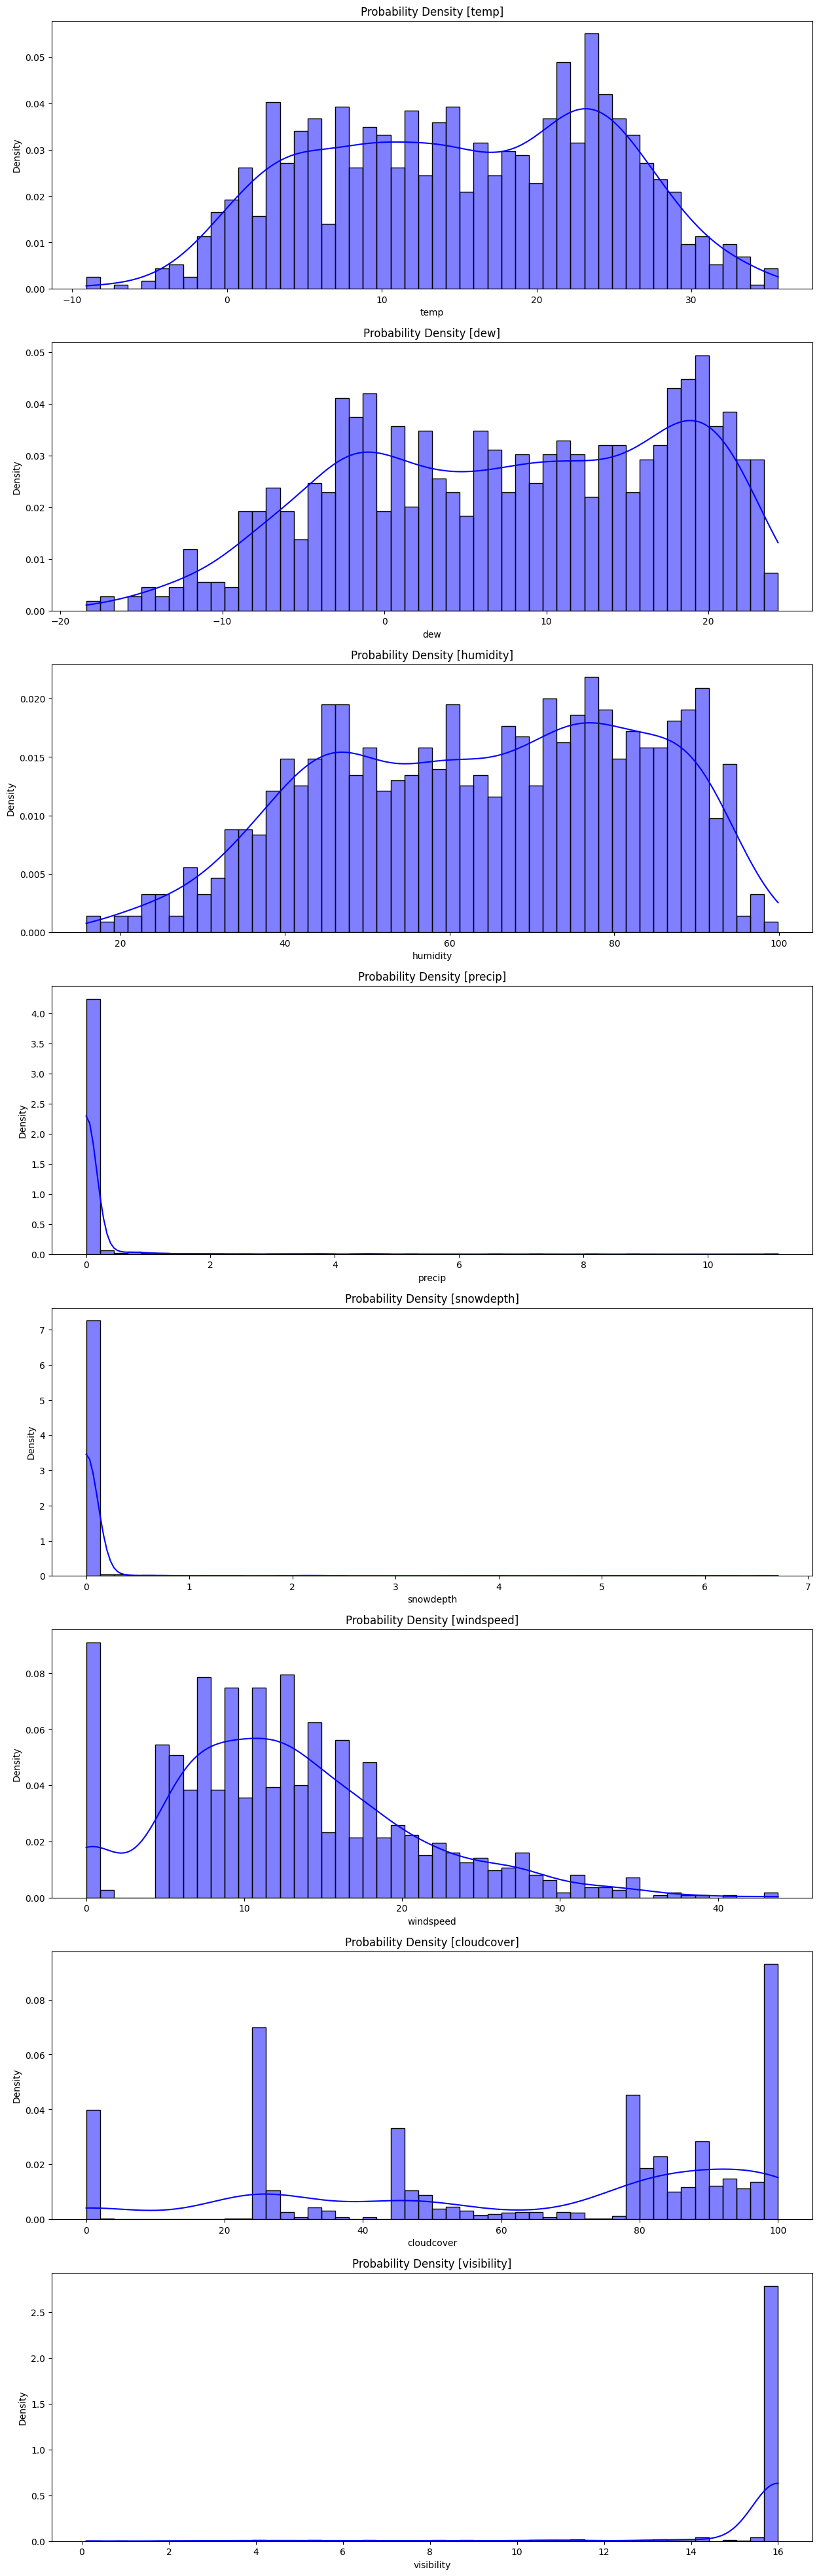

In [23]:
## Before scaling
density_plot(bike_df)

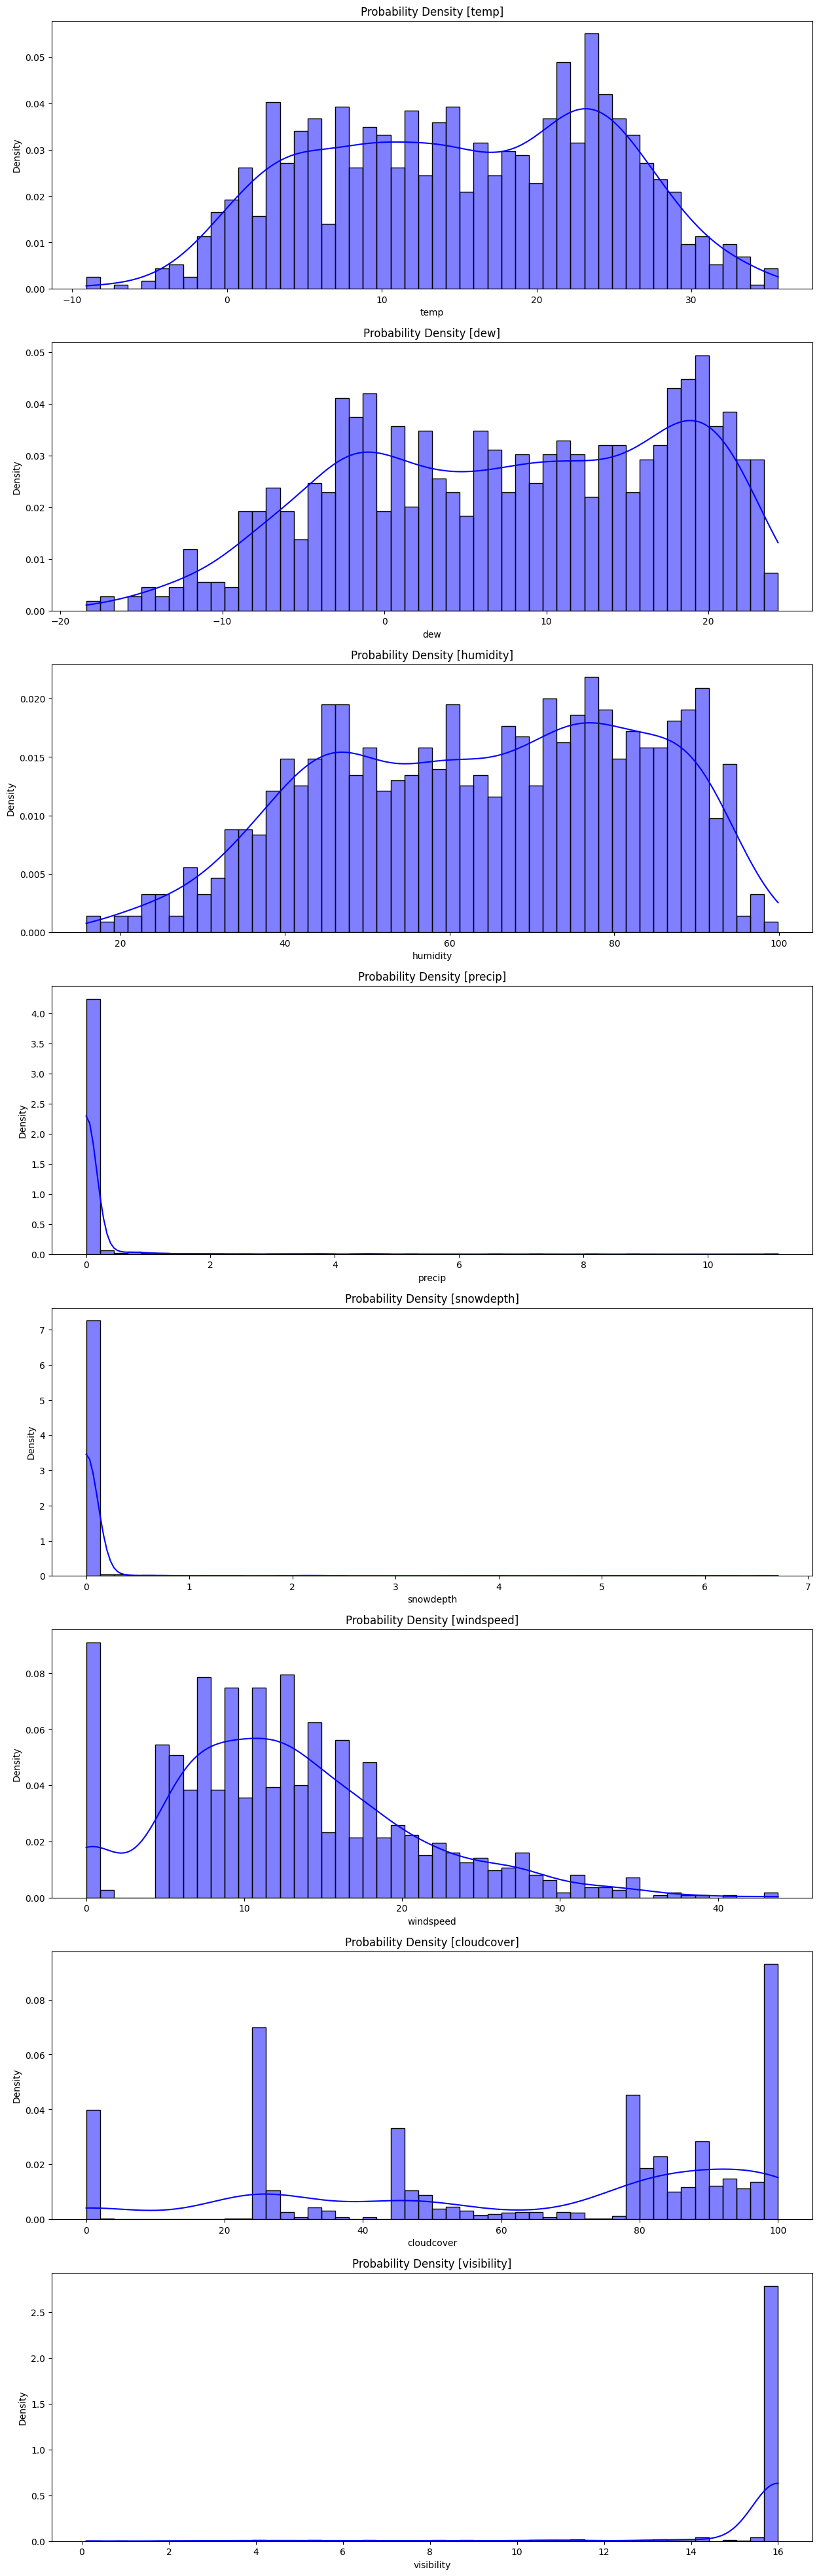

In [24]:
density_plot(bike_validation_df)

In [25]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
bike_df.loc[:,con_features] = scale.fit_transform(X=bike_df.loc[:,con_features])
bike_validation_df.loc[:,con_features] = scale.transform(X=bike_validation_df.loc[:,con_features])

In [26]:
## after scaling
bike_df.loc[:,con_features].describe()

,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility
count,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03
mean,3.247402e-16,5.551115e-18,4.954370e-16,-1.908196e-17,2.775558e-18,6.106227e-17,-2.775558e-17,2.581269e-16
std,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00
min,-2.598406e+00,-2.605264e+00,-2.550479e+00,-1.590760e-01,-1.098795e-01,-1.671585e+00,-1.967697e+00,-6.428529e+00
25%,-7.978207e-01,-8.526544e-01,-8.552327e-01,-1.590760e-01,-1.098795e-01,-7.113015e-01,-9.797663e-01,2.798452e-01
50%,3.280642e-02,5.352429e-02,8.047592e-02,-1.590760e-01,-1.098795e-01,-8.841466e-02,4.484298e-01,2.798452e-01
75%,8.634335e-01,9.298289e-01,8.248495e-01,-1.590760e-01,-1.098795e-01,5.734027e-01,8.627971e-01,2.798452e-01
max,2.192437e+00,1.646805e+00,1.882269e+00,1.606021e+01,1.418910e+01,4.012257e+00,1.079121e+00,2.798452e-01


In [27]:
bike_validation_df.loc[:,con_features].describe()

,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.035586,-0.005850,-0.072900,0.093613,-0.094297,0.130528,-0.039556,0.015624
std,0.963762,0.992119,1.029402,2.235382,0.136345,1.025850,0.988281,0.897398
min,-2.523382,-2.605264,-2.399627,-0.159076,-0.109879,-1.671585,-1.967697,-5.373753
25%,-0.736194,-0.787927,-0.921297,-0.159076,-0.109879,-0.516649,-1.164861,0.279845
50%,0.038165,0.003734,-0.044268,-0.159076,-0.109879,-0.010554,0.448430,0.279845
75%,0.809845,0.840207,0.840146,-0.159076,-0.109879,0.680461,0.807954,0.279845
max,2.117413,1.587057,1.882269,37.531487,1.445748,3.259602,1.079121,0.279845


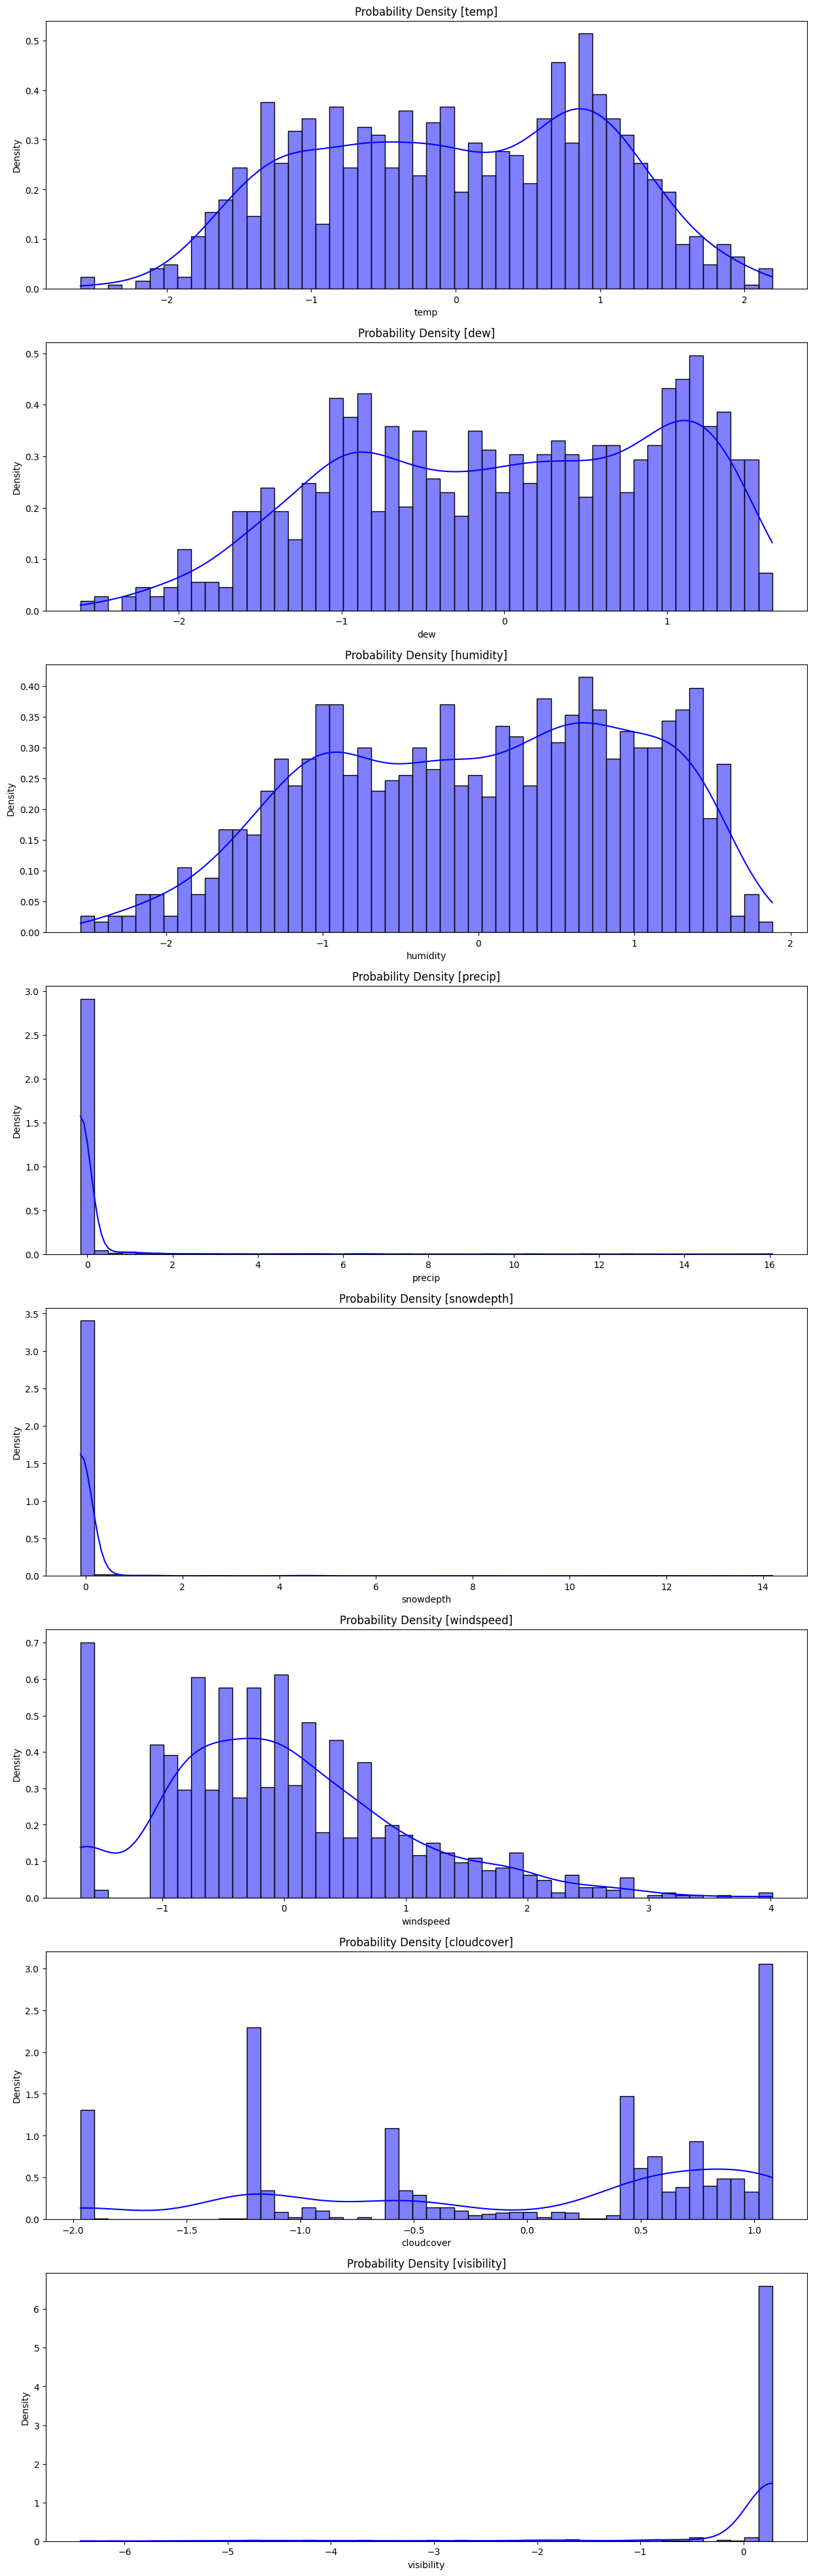

In [28]:
density_plot(bike_df)

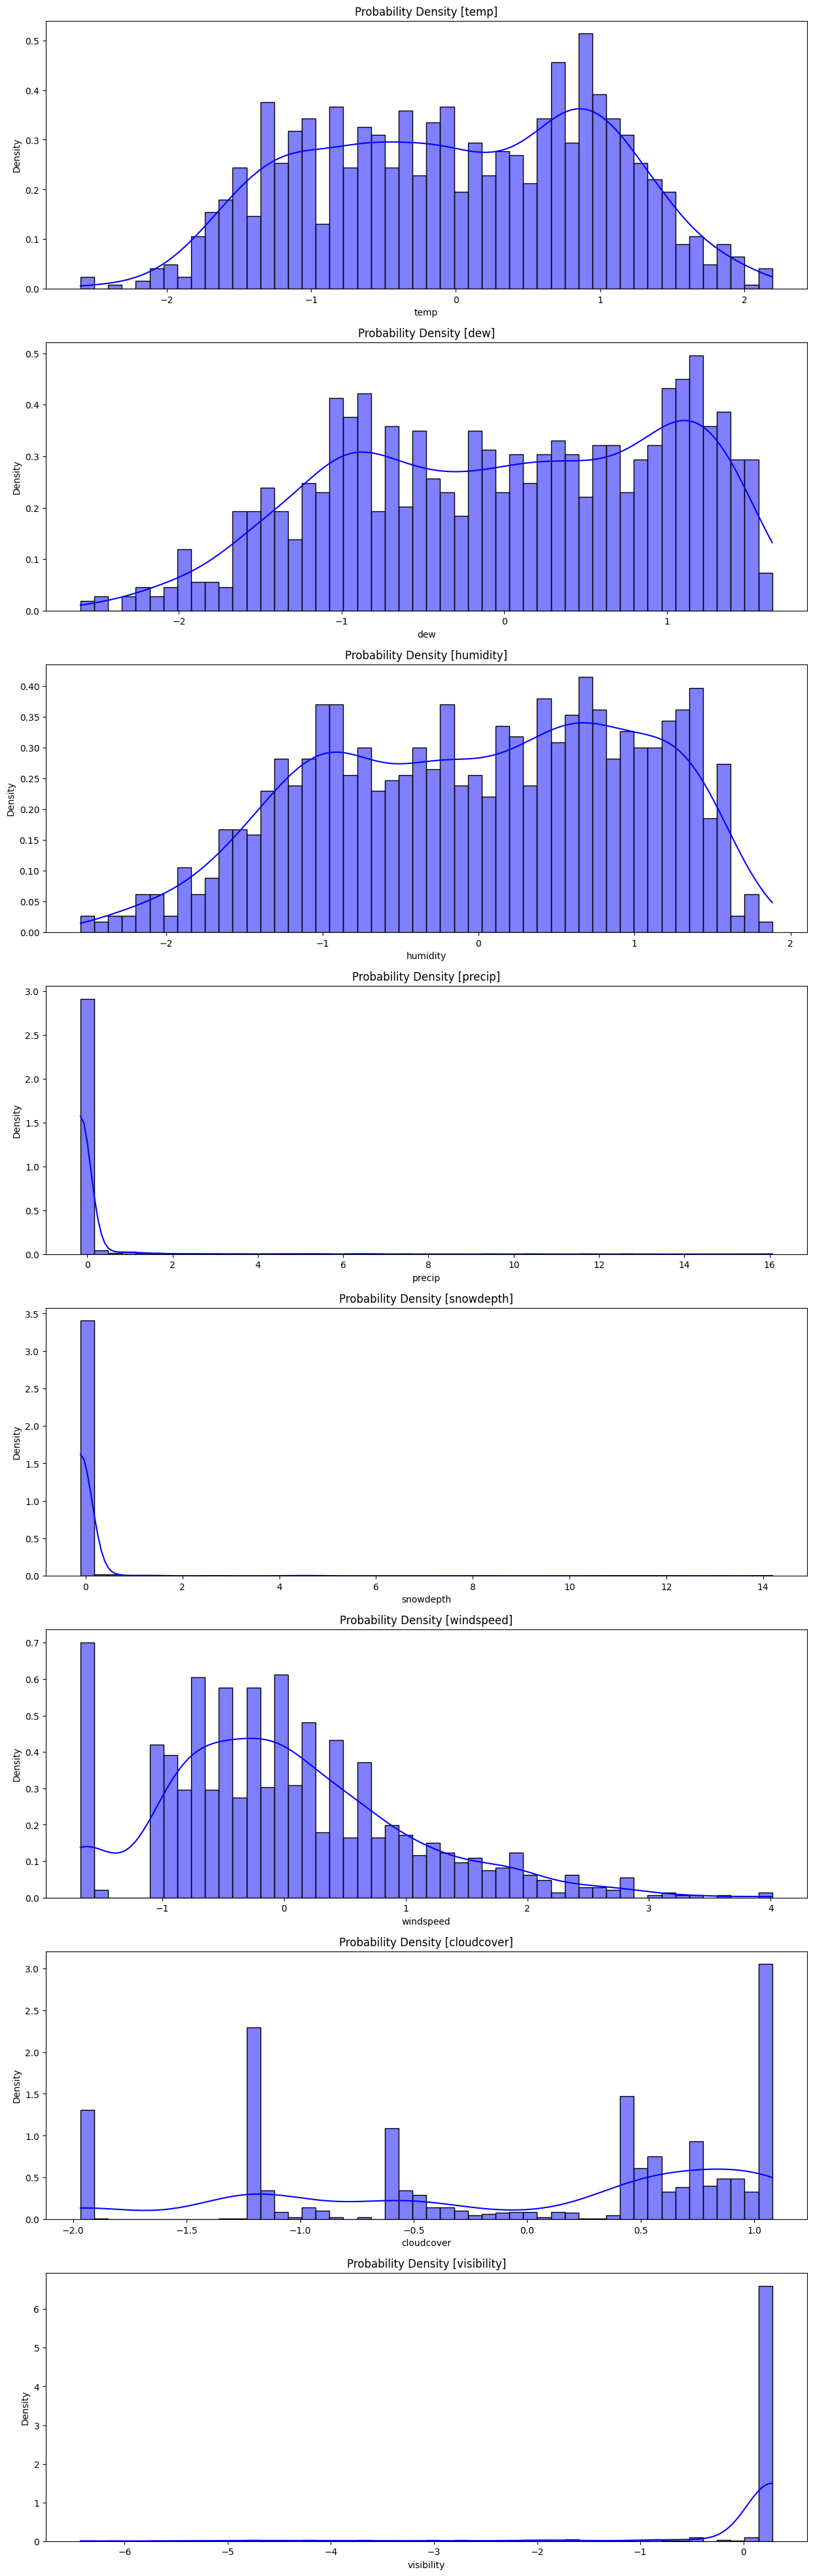

In [29]:
density_plot(bike_validation_df)

In [30]:
## drop snow and dew columns
## dew <-- coz its corelated
## snow <-- because its blank

bike_df = bike_df.drop(['snow','dew'], axis=1)
bike_validation_df = bike_validation_df.drop(['snow','dew'], axis=1)

In [31]:
## Test -----------------------------##
## Say I remove Weekday
## Say I remove summertime
bike_df = bike_df.drop(['weekday_1','summertime_1'], axis=1)
bike_validation_df = bike_validation_df.drop(['weekday_1','summertime_1'], axis=1)

In [32]:
bike_df.head()

,temp,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,holiday_1
688,0.284674,-2.146447,-0.159076,-0.109879,-0.698325,-1.967697,0.279845,1,-0.866025,-0.500000,0.000000,1.000000,1.000000e+00,6.123234e-17,0
1514,-1.708831,-0.376829,-0.159076,-0.109879,-0.516649,-1.967697,0.279845,0,0.707107,0.707107,0.000000,1.000000,0.000000e+00,1.000000e+00,1
1456,-1.580218,0.465519,-0.159076,-0.109879,-0.542603,0.747018,0.279845,0,0.965926,-0.258819,0.781831,0.623490,0.000000e+00,1.000000e+00,0
1332,0.927740,1.600079,-0.127025,-0.109879,-0.542603,-0.916545,0.279845,0,-0.707107,0.707107,0.974928,-0.222521,1.224647e-16,-1.000000e+00,0
811,-1.344427,0.723973,-0.159076,-0.109879,-0.386881,0.747018,0.279845,0,0.866025,0.500000,-0.433884,-0.900969,0.000000e+00,1.000000e+00,0


In [33]:
bike_validation_df.head()

,temp,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,holiday_1
1180,0.306110,1.131170,-0.159076,-0.109879,-0.802139,0.448430,0.279845,0,0.965926,-2.588190e-01,-0.433884,-0.900969,-1.000000e+00,-1.836970e-16,0
799,0.959893,1.170729,-0.159076,-0.109879,-0.996791,0.448430,0.068890,0,0.500000,8.660254e-01,-0.781831,0.623490,-5.000000e-01,-8.660254e-01,0
1099,0.691949,1.558938,37.531487,-0.109879,2.909228,1.036466,-5.373753,0,0.707107,7.071068e-01,0.781831,0.623490,1.224647e-16,-1.000000e+00,0
922,1.281427,-1.239221,-0.159076,-0.109879,-0.088415,-0.971388,0.279845,1,-0.866025,-5.000000e-01,-0.974928,-0.222521,-8.660254e-01,-5.000000e-01,0
781,-1.762420,1.319472,-0.159076,-0.003330,-0.166276,1.079121,-2.293808,0,1.000000,6.123234e-17,-0.781831,0.623490,5.000000e-01,8.660254e-01,0


## Data Modeling
* Apply Naive classfier
* Will always predict 'low_bike_demand'
* Something that forms a benchmark

## Metrics
* Accuracy
* F1 score
* Precision and Recall

In [34]:
X_train = np.array(bike_df.drop(['increase_stock'], axis=1))
y_train = np.array(bike_df['increase_stock'])

In [35]:
X_valid = np.array(bike_validation_df.drop(['increase_stock'], axis=1))
y_valid = np.array(bike_validation_df['increase_stock'])

In [36]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy='constant', constant=0, random_state=42)

In [37]:
dummy_classifier.fit(X_train, y_train)

DummyClassifier(constant=0, random_state=42, strategy='constant')

In [38]:
from sklearn.metrics import accuracy_score, classification_report

In [39]:
predict = dummy_classifier.predict(X_valid)

## metrics
## classification report
print(classification_report(y_valid,predict))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       262
           1       0.00      0.00      0.00        58

    accuracy                           0.82       320
   macro avg       0.41      0.50      0.45       320
weighted avg       0.67      0.82      0.74       320



* benchmark precision
* benchmark recall
* benchmark F1 Score
* benchmark accuracy

## Vanilla Logistic Regression

**Hyper-parameters to fine-tune**
* penalty
* lambda
* solver
* max_iter
* class_weights

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score

In [41]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1050,  230]))

In [42]:
## Possible set of hyper-parameter values
params = {
'penalty': ['l1','l2', 'elasticnet', None],
'C': [0.02,0.05,0.1,0.2,0.5,1,5,10],
'max_iter': [1,3,5,10,50,75,100],
'class_weight': [None,'balanced',{1:1.25,0:1},{1:1.5,0:1},{1:2,0:1},{1:2.25,0:1},{1:2.5,0:1}],
'solver': ['lbfgs','liblinear','newton-cg','newton-cholesky','saga']}

In [43]:
def custom_score(y_true, y_pred, beta=0.0001):

    s1 = f1_score(y_true,y_pred)
    s2 = recall_score(y_true,y_pred)
    return s1+(beta*s2) # prioritize F1 score

In [44]:
custom_metric = make_scorer(custom_score, greater_is_better=True)

In [45]:
logistic_regression = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=logistic_regression,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           scoring='f1')

In [46]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7840 candidates, totalling 39200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10],
                         'class_weight': [None, 'balanced', {0: 1, 1: 1.25},
                                          {0: 1, 1: 1.5}, {0: 1, 1: 2},
                                          {0: 1, 1: 2.25}, {0: 1, 1: 2.5}],
                         'max_iter': [1, 3, 5, 10, 50, 75, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'saga']},
             scoring='f1', verbose=1)

In [47]:
grid_search_estimator = grid_search.best_estimator_
grid_search.best_params_

{'C': 0.2,
 'class_weight': {1: 2.5, 0: 1},
 'max_iter': 5,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [48]:
print(classification_report(y_valid,grid_search_estimator.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       262
           1       0.51      0.79      0.62        58

    accuracy                           0.82       320
   macro avg       0.73      0.81      0.75       320
weighted avg       0.87      0.82      0.84       320



## SMOTE
* oversampling *high_bike_demand* labels
* sampling strategy

In [49]:
from imblearn.over_sampling import SMOTENC

In [50]:
over_sample = SMOTENC(categorical_features=[13],
                      sampling_strategy=0.4,
                      random_state=42)

In [51]:
X_train_resample, y_train_resample = over_sample.fit_resample(X_train, y_train)

In [52]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_resample, return_counts=True))

(array([0, 1]), array([1050,  230]))
(array([0, 1]), array([1050,  420]))


Run grid-search to find new set of optimal hyper-parameters

In [53]:
grid_search.fit(X_train_resample, y_train_resample)

Fitting 5 folds for each of 7840 candidates, totalling 39200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10],
                         'class_weight': [None, 'balanced', {0: 1, 1: 1.25},
                                          {0: 1, 1: 1.5}, {0: 1, 1: 2},
                                          {0: 1, 1: 2.25}, {0: 1, 1: 2.5}],
                         'max_iter': [1, 3, 5, 10, 50, 75, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'saga']},
             scoring='f1', verbose=1)

In [54]:
resample_grid_search_estimator = grid_search.best_estimator_
grid_search.best_params_

{'C': 0.2,
 'class_weight': {1: 2, 0: 1},
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

In [55]:
print(classification_report(y_valid,resample_grid_search_estimator.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       262
           1       0.45      0.81      0.58        58

    accuracy                           0.78       320
   macro avg       0.70      0.79      0.72       320
weighted avg       0.86      0.78      0.80       320



## Logistic Regression with feature engineering

In [56]:
bike_df.head()

,temp,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,holiday_1
688,0.284674,-2.146447,-0.159076,-0.109879,-0.698325,-1.967697,0.279845,1,-0.866025,-0.500000,0.000000,1.000000,1.000000e+00,6.123234e-17,0
1514,-1.708831,-0.376829,-0.159076,-0.109879,-0.516649,-1.967697,0.279845,0,0.707107,0.707107,0.000000,1.000000,0.000000e+00,1.000000e+00,1
1456,-1.580218,0.465519,-0.159076,-0.109879,-0.542603,0.747018,0.279845,0,0.965926,-0.258819,0.781831,0.623490,0.000000e+00,1.000000e+00,0
1332,0.927740,1.600079,-0.127025,-0.109879,-0.542603,-0.916545,0.279845,0,-0.707107,0.707107,0.974928,-0.222521,1.224647e-16,-1.000000e+00,0
811,-1.344427,0.723973,-0.159076,-0.109879,-0.386881,0.747018,0.279845,0,0.866025,0.500000,-0.433884,-0.900969,0.000000e+00,1.000000e+00,0


**Numerical features to combine:-**
* temp and humidity
* temp and precip
* temp and windspeed
* temp and snowdepth
* humidity and precip
* humidity and windspeed
* precip and snowdepth
* precip and cloudcover
* precip and windspeed
* precip and visibility
* windspeed and cloudcover

---

**Categorical features to combine:-**
* hour_of_day and day_of_week
* day_of_week and month
* hour_of_day and month

In [57]:
## Could have used the lib
def feature_polynomial(X):

    return np.concatenate((X,
        (X[:,0]*X[:,1]).reshape((X.shape[0],1)),
        (X[:,0]*X[:,2]).reshape((X.shape[0],1)),
        (X[:,0]*X[:,4]).reshape((X.shape[0],1)),
        (X[:,0]*X[:,3]).reshape((X.shape[0],1)),
        (X[:,1]*X[:,2]).reshape((X.shape[0],1)),
        (X[:,1]*X[:,4]).reshape((X.shape[0],1)),
        (X[:,2]*X[:,3]).reshape((X.shape[0],1)),
        (X[:,2]*X[:,5]).reshape((X.shape[0],1)),
        (X[:,2]*X[:,4]).reshape((X.shape[0],1)),
        (X[:,2]*X[:,6]).reshape((X.shape[0],1)),
        (X[:,4]*X[:,5]).reshape((X.shape[0],1)),
        (X[:,7]*X[:,9]).reshape((X.shape[0],1)),
        (X[:,8]*X[:,10]).reshape((X.shape[0],1)),
        (X[:,7]*X[:,11]).reshape((X.shape[0],1)),
        (X[:,8]*X[:,12]).reshape((X.shape[0],1)),
        (X[:,9]*X[:,11]).reshape((X.shape[0],1)),
        (X[:,10]*X[:,12]).reshape((X.shape[0],1))), axis=1)

In [58]:
X_train_fe = feature_polynomial(X_train)
X_valid_fe = feature_polynomial(X_valid)

In [59]:
X_train_fe[0]

array([ 2.84673999e-01, -2.14644725e+00, -1.59076035e-01, -1.09879487e-01,
       -6.98324734e-01, -1.96769715e+00,  2.79845224e-01, -8.66025404e-01,
       -5.00000000e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        6.12323400e-17,  0.00000000e+00, -6.11037722e-01, -4.52848111e-02,
       -1.98794895e-01, -3.12798329e-02,  3.41448318e-01,  1.49891721e+00,
        1.74791931e-02,  3.13013462e-01,  1.11086730e-01, -4.45166687e-02,
        1.37409159e+00, -0.00000000e+00, -5.00000000e-01, -8.66025404e-01,
       -3.06161700e-17,  0.00000000e+00,  6.12323400e-17])

In [60]:
grid_search.fit(X_train_fe, y_train)

Fitting 5 folds for each of 7840 candidates, totalling 39200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.02, 0.05, 0.1, 0.2, 0.5, 1, 5, 10],
                         'class_weight': [None, 'balanced', {0: 1, 1: 1.25},
                                          {0: 1, 1: 1.5}, {0: 1, 1: 2},
                                          {0: 1, 1: 2.25}, {0: 1, 1: 2.5}],
                         'max_iter': [1, 3, 5, 10, 50, 75, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'saga']},
             scoring='f1', verbose=1)

In [61]:
fe_grid_search_estimator = grid_search.best_estimator_
grid_search.best_params_

{'C': 0.02,
 'class_weight': {1: 1.5, 0: 1},
 'max_iter': 50,
 'penalty': None,
 'solver': 'lbfgs'}

In [62]:
print(classification_report(y_valid,fe_grid_search_estimator.predict(X_valid_fe)))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       262
           1       0.64      0.64      0.64        58

    accuracy                           0.87       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.87      0.87      0.87       320



**For each model**
* Draw ROC curve
* Get Optimal threshold
* Get new prediction
* Save the models

In [63]:
from joblib import dump

In [64]:
from sklearn.metrics import roc_curve, precision_recall_curve

In [65]:
## Save and plot curve
## Save model
def model_summary(model,X_train=None,y_train=None):

    probability = model.predict_proba(X_train)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_train , probability)

    plt.figure(figsize=(10,7))
    sns.lineplot(x=thresholds, y=precision[:-1], seed=42, color='cyan')
    sns.lineplot(x=thresholds, y=recall[:-1], seed=42, color='orange')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision vs Recall')

    plt.legend()
    plt.grid()
    plt.show()

    plt.savefig(f'/content/{model}.png')

    f1_score = 2*(precision[:-1]*recall[:-1])/(precision[:-1]+recall[:-1]+1e-10)
    optimal_threshold = thresholds[np.argmax(f1_score)]
    print(f'Optimal Threshold at: {optimal_threshold}')

    dump(model, f'/content/{model}.joblib')

    with open(f'/content/{model}.txt', 'w') as f:
        f.write(f'Optimal Threshold at: {optimal_threshold}')

    return model,optimal_threshold

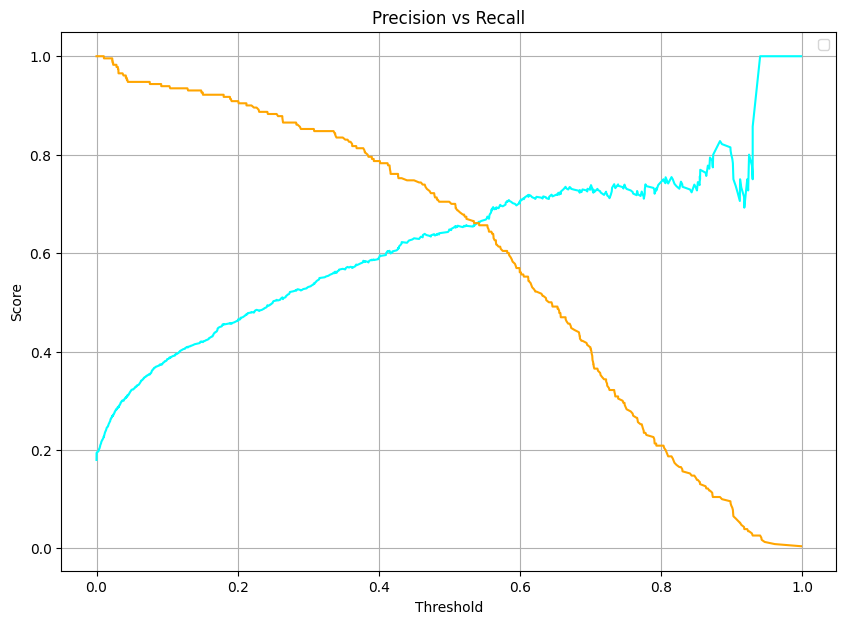

Optimal Threshold at: 0.46529791770951917


<Figure size 640x480 with 0 Axes>

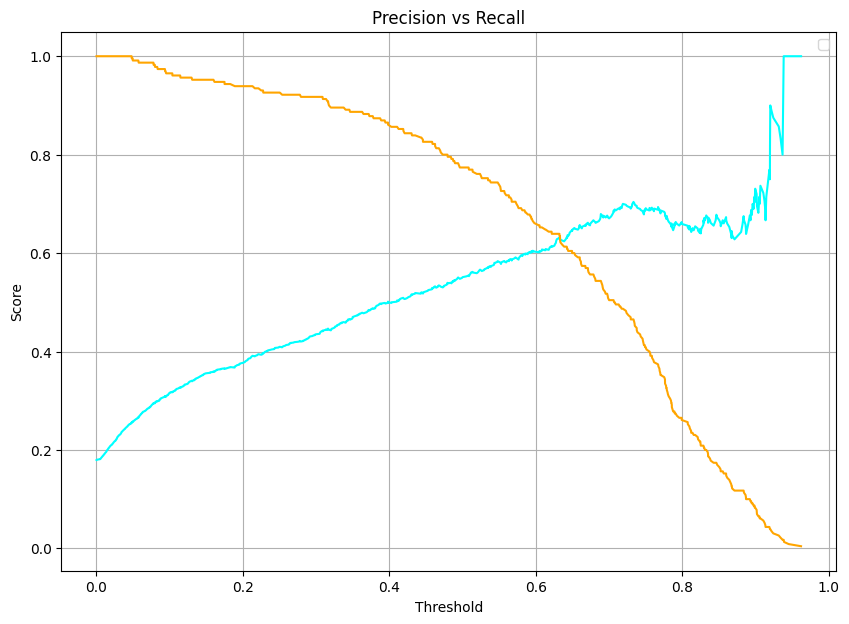

Optimal Threshold at: 0.5480615174225469


<Figure size 640x480 with 0 Axes>

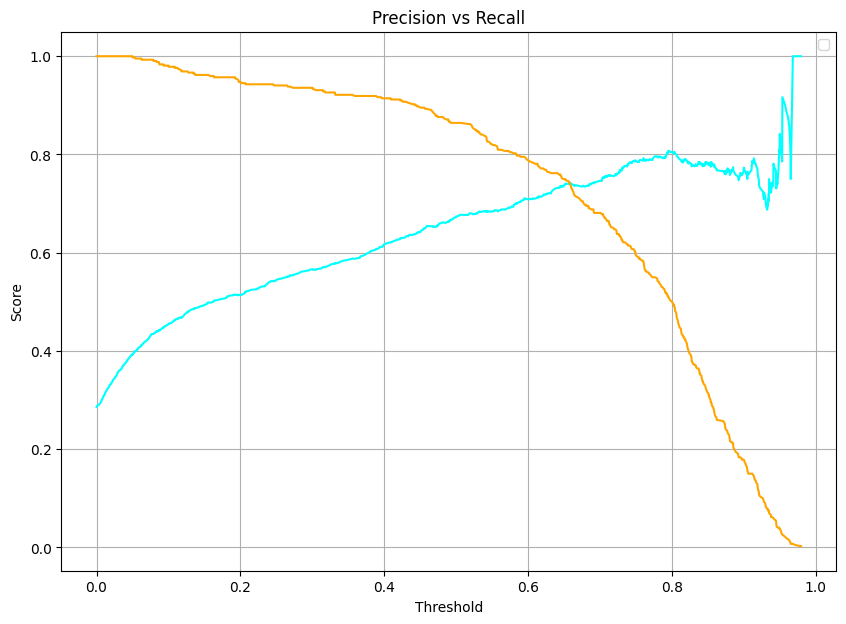

Optimal Threshold at: 0.519449791454019


<Figure size 640x480 with 0 Axes>

In [66]:
fe_estimator, fe_threshold = model_summary(fe_grid_search_estimator,
                                           X_train_fe, y_train)
vanilla_estimator,vanilla_threshold = model_summary(grid_search_estimator,
                                                     X_train, y_train)
resample_estimator, resample_threshold = model_summary(resample_grid_search_estimator,
                                                       X_train_resample, y_train_resample)

## Classification Report for Test data

In [67]:
## Vanilla Model
probability = vanilla_estimator.predict_proba(X_valid)[:,1]
print(classification_report(y_valid,(probability >= vanilla_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       262
           1       0.58      0.78      0.66        58

    accuracy                           0.86       320
   macro avg       0.76      0.82      0.79       320
weighted avg       0.88      0.86      0.86       320



In [68]:
## SMOTE Model
probability = resample_estimator.predict_proba(X_valid)[:,1]
print(classification_report(y_valid,(probability >= resample_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87       262
           1       0.46      0.79      0.59        58

    accuracy                           0.80       320
   macro avg       0.71      0.80      0.73       320
weighted avg       0.86      0.80      0.81       320



In [69]:
# FE model
probability = fe_estimator.predict_proba(X_valid_fe)[:,1]
print(classification_report(y_valid,(probability >= fe_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       262
           1       0.63      0.72      0.67        58

    accuracy                           0.87       320
   macro avg       0.78      0.81      0.80       320
weighted avg       0.88      0.87      0.88       320

